<a href="https://colab.research.google.com/github/Stefano-Previti/Diffusion_Based_Generative_Refiner/blob/main/Diffiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OVERVIEW OF THE PROJECT**

**⏰Citation**

Diffiner: A Versatile Diffusion-based Generative Refiner for Speech Enhancement.Ryosuke Sawata, Naoki Murata, Yuhta Takida, Toshimitsu Uesaka, Takashi Shibuya, Shusuke Takahashi, Yuki Mitsufuji. https://doi.org/10.48550/arXiv.2210.17287

⚓
 First the training of a diffusion-based generative model on
clean speech data. After obtaining results from an arbitrary preceding SE module, the variance of the noise included in noisy
input at each time-frequency bin is estimated. With the estimate, the proposed refiner generates clean speech on the basis of
the DDRM framework, which utilizes the pre-trained diffusionbased model.

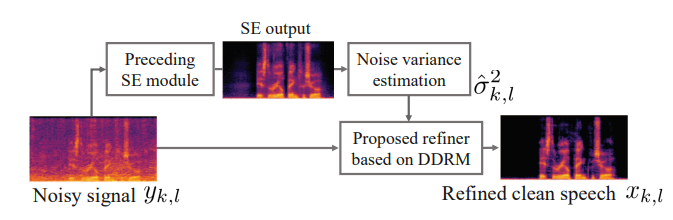

**▶LOAD** **THE** **DATASET**

⚓Loading of clean and noisy dataset composed, in both cases, by 28 speakers.

⏰**Citation**

Valentini-Botinhao, Cassia. (2017). Noisy speech database for training speech enhancement algorithms and TTS models, 2016 [sound]. University of Edinburgh. School of Informatics. Centre for Speech Technology Research (CSTR). https://doi.org/10.7488/ds/2117.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

# Defining paths to your ZIP files on Google Drive
zip_clean_train = '/content/drive/My Drive/clean_trainset_28spk_wav.zip'
zip_noisy_train = '/content/drive/My Drive/noisy_trainset_28spk_wav.zip'
zip_clean_test = '/content/drive/My Drive/clean_testset_wav.zip'
zip_noisy_test = '/content/drive/My Drive/noisy_testset_wav.zip'

# Defining extraction directories
clean_dir = '/content/data/clean_trainset/'
noisy_dir = '/content/data/noisy_trainset/'
clean_test_dir = '/content/data/clean_testset/'
noisy_test_dir = '/content/data/noisy_testset/'

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Creation of directories for extraction
create_directory(clean_dir)
create_directory(noisy_dir)
create_directory(clean_test_dir)
create_directory(noisy_test_dir)

# Function to extract ZIP files
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extraction of each ZIP file to its corresponding directory
extract_zip(zip_clean_train, clean_dir)
extract_zip(zip_noisy_train, noisy_dir)
extract_zip(zip_clean_test, clean_test_dir)
extract_zip(zip_noisy_test, noisy_test_dir)




Mounted at /content/drive


In [ ]:
#  Verification of the extraction by listing files in all subdirectories
def verify_extraction(directory, num_files_to_check=6):
    # Walking through all directories and files
    for root, dirs, files in os.walk(directory):
        print(f'Checking directory: {root}')

        # Showing some files (up to num_files_to_check) in this directory
        for i, file_name in enumerate(files[:num_files_to_check]):
            file_path = os.path.join(root, file_name)
            print(f'File {i+1}: {file_path}')

# Running the verification functions
verify_extraction(clean_dir)
verify_extraction(noisy_dir)
verify_extraction(clean_test_dir)
verify_extraction(noisy_test_dir)


⚓Creation of a custom dataset object.

⏰The choiche is to load only 1/4 of each dataset,after a random shuffling, because of the limitation of the RAM in the colab enviroment.

In [ ]:
# Installing PyTorch and torchaudio
!pip install torch torchvision torchaudio

In [ ]:
import torch
import torchaudio
import random
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, data_dir):
        """
        Initialization of the dataset with audio files from the specified directory and its subdirectories.
        """
        self.data_dir = data_dir
        self.files = self._get_subset_of_audio_files(data_dir)

    def _get_subset_of_audio_files(self, directory):
        """
        Recursively collecting a subset (1/4) of all audio files in the directory and its subdirectories.
        """
        audio_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.wav'):
                    audio_files.append(os.path.join(root, file))

        # Shuffling the list of files and taking 1/4 of it
        random.shuffle(audio_files)
        index = len(audio_files) // 4
        return sorted(audio_files[:index])


    def __len__(self):
        """Returning the number of audio files."""
        return len(self.files)

    def __getitem__(self, idx):
        """
        Loading and returning the waveform and sample rate for a specific index.
        """
        file_path = os.path.join(self.data_dir, self.files[idx])
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_path} is not a file")

        waveform, sample_rate = torchaudio.load(file_path)
        return {'waveform': waveform, 'sample_rate': sample_rate}

    def compute_stft(self,waveform):
     """
     Computing the STFT of the waveform using a Hann window and returning a
     256x256 tensor with real and imaginary parts as separate channels.
     """
     # Defining th STFT parameters
     n_fft = 512
     hop_length = 256
     win_length = 512
     window_fn = torch.hann_window

     # Performing STFT
     stft_transform = T.Spectrogram(
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window_fn=window_fn,
        power=None,
     )
     stft_spectrogram = stft_transform(waveform)

     # Truncation of the DC component
     stft_spectrogram = stft_spectrogram[:, 1:, :]

     # Extraction of real and imaginary parts
     real_part = stft_spectrogram.real
     imag_part = stft_spectrogram.imag

     # Stacking into a tensor with two channels
     two_channel_tensor = torch.stack((real_part, imag_part), dim=1)

     # Ensuring the size is 256x256 for the selected time frames and frequency bins
     two_channel_tensor = two_channel_tensor[:, :, :256, :256]

     return two_channel_tensor

# Parameters
batch_size = 8

# Creation of dataset instances
clean_train_dataset = AudioDataset(clean_dir)
noisy_train_dataset = AudioDataset(noisy_dir)
clean_test_dataset = AudioDataset(clean_test_dir)
noisy_test_dataset = AudioDataset(noisy_test_dir)

# Print dataset lengths
print("Number of samples in clean_train_dataset:", len(clean_train_dataset))
print("Number of samples in noisy_train_dataset:", len(noisy_train_dataset))
print("Number of samples in clean_test_dataset:", len(clean_test_dataset))
print("Number of samples in noisy_test_dataset:", len(noisy_test_dataset))

#Custom collate function to handle variable-length audio files in order to avoid the runtime exception of the DataLoader
def collate_fn(batch):
    waveforms = [item['waveform'] for item in batch]
    sample_rates = [item['sample_rate'] for item in batch]
    return {'waveform': waveforms, 'sample_rate': sample_rates}

# Creation of DataLoader instances
clean_train_loader = DataLoader(clean_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
clean_test_loader = DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Debug: Iteration over the first few batches of the clean_train_loader to see what's loaded
for batch_idx, batch in enumerate(clean_train_loader):
    print(f"Batch {batch_idx} Loaded")
    for idx in range(len(batch['waveform'])):
        waveform = batch['waveform'][idx]
        sample_rate = batch['sample_rate'][0]

        # Print details for each waveform
        print(f"Sample {idx} - Waveform shape: {waveform.shape}, Sample rate: {sample_rate}")

        if idx >= 1:  # Limit to first few samples for brevity
            break
    if batch_idx >= 1:  # Limit to first few batches for brevity
        break



▶**PREPROCESSING OF THE DATA**

⚓Here the pre-processing of the data through the computation
of the STFT parameters.

The **short-time Fourier transform** (STFT) is used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time.The procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment in order to reveal its spectrum.

In [ ]:
def STFT_preprocess_and_save(dataset,data_loader, output_dir):
    """
    Preprocesses the dataset by computing the STFT for each waveform and saving each STFT tensor as a separate file.

    Parameters:
    - data_loader: A DataLoader object providing batches of audio data.
    - output_dir: The directory where the individual STFT tensor files will be saved.
    """
    # Ensuring the destination directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialization of a counter for processed files
    file_counter = 0

    # Iterate over each batch in the data loader
    for batch_index, batch_data in enumerate(data_loader):
        # Assuming batch_data is a dictionary containing 'waveform'
        waveforms = batch_data['waveform']

        # Computing the STFT for each waveform in the batch
        for waveform_index, waveform in enumerate(waveforms):
            # Computing the STFT for the current waveform
            stft_tensor = dataset.compute_stft(waveform)

            # Definition of the file name for the current tensor
            file_name = f"stft_tensor_{file_counter}.pt"
            file_path = os.path.join(output_dir, file_name)

            # Saving the STFT tensor to a file
            torch.save(stft_tensor, file_path)

            # Incrementing the file counter
            file_counter += 1

            # Logging progress every 10 files
            if file_counter % 10 == 0:
                print(f"File {file_counter}/{len(data_loader.dataset)} processed and saved to {file_path}")

    print(f"All tensors have been processed and saved to {output_dir}")

# Directory Paths
STFT_clean_preprocessed_dir = '/content/drive/My Drive/STFT_clean_preprocessed/'
STFT_clean_test_preprocessed_dir = '/content/drive/My Drive/STFT_clean_test_preprocessed/'
STFT_noisy_preprocessed_dir = '/content/drive/My Drive/STFT_noisy_preprocessed/'
STFT_noisy_test_preprocessed_dir = '/content/drive/My Drive/STFT_noisy_test_preprocessed/'

#Calling the function
STFT_preprocess_and_save(clean_train_dataset,clean_train_loader, STFT_clean_preprocessed_dir)
STFT_preprocess_and_save(clean_test_dataset,clean_test_loader, STFT_clean_test_preprocessed_dir)
STFT_preprocess_and_save(noisy_train_dataset,noisy_train_loader, STFT_noisy_preprocessed_dir)
STFT_preprocess_and_save(noisy_test_dataset,noisy_test_loader, STFT_noisy_test_preprocessed_dir)


⚓Here the preprocessing for the waveform of each audio.

⏰This is a very huge simplifaction because we are resampling to 16khz and then there is the extraction of a **random** window of 16384 samples, so that means that the model will work, for each audio, with an extacted part of about 1 second.

In this  way there is a reduction in the number of data processed by the model,infact the original paper divides the input in multiple segment of 16384 samples,obtaining from 1 to even 5 segment for each audio (so from 1 to 5 seconds).


In [ ]:
def waveform_preprocess_and_save(dataloader, output_dir, segment_length=16384):
    """
    Preprocess audio data from a DataLoader and save the preprocessed files.

    Args:
        dataloader (DataLoader): DataLoader instance that provides audio data.
        output_dir (str): Directory to save the preprocessed data.
        segment_length (int): Length of audio segments in samples.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for batch_idx, batch in enumerate(dataloader):
        for idx in range(len(batch['waveform'])):
            waveform = batch['waveform'][idx]
            sample_rate = batch['sample_rate'][0]

            # Resampling if necessary
            target_sample_rate = 16000
            if sample_rate != target_sample_rate:
                resample_transform = T.Resample(sample_rate, target_sample_rate)
                waveform = resample_transform(waveform)

            # Normalizing waveform
            waveform = waveform / waveform.abs().max()

            # Segmenting and padding the audio
            length = waveform.size(1)
            if length >= segment_length:
                start = random.randint(0, length - segment_length)
                segment = waveform[:, start:start + segment_length]
            else:
                padding = segment_length - length
                segment = torch.nn.functional.pad(waveform, (0, padding), 'constant', 0)

            # Saving the preprocessed data
            file_name = f"sample_{batch_idx}_{idx}.pt"
            save_path = os.path.join(output_dir, file_name)
            torch.save(segment, save_path)

            print(f"Saved preprocessed data: {save_path}")

# Directory Paths
waveform_clean_preprocessed_dir = '/content/drive/My Drive/waveform_clean_preprocessed/'
waveform_clean_test_preprocessed_dir='/content/drive/My Drive/waveform_clean_test_preprocessed/'
waveform_noisy_preprocessed_dir = '/content/drive/My Drive/waveform_noisy_preprocessed/'
waveform_noisy_test_preprocessed_dir = '/content/drive/My Drive/waveform_noisy_test_preprocessed/'

#Calling the function
waveform_preprocess_and_save(clean_train_loader, waveform_clean_preprocessed_dir)
waveform_preprocess_and_save(clean_test_loader, waveform_clean_test_preprocessed_dir)
waveform_preprocess_and_save(noisy_train_loader, waveform_noisy_preprocessed_dir)
waveform_preprocess_and_save(noisy_test_loader, waveform_noisy_test_preprocessed_dir)


**SEGAN**

**⏰Citation**

SEGAN: Speech Enhancement Generative Adversarial Network.Santiago Pascual, Antonio Bonafonte, Joan Serrà. https://doi.org/10.48550/arXiv.1703.09452

⚓
The **SEGAN** (Speech Enhancement Generative Adversarial Network) architecture is model designed for speech enhancement tasks, particularly to reduce noise in audio signals. It uses a generative adversarial network (GAN) framework, where a generator network aims to produce clean, enhanced speech from noisy input, and a discriminator network attempts to distinguish between the enhanced speech and the original clean speech. Through this **adversarial training**, the SEGAN model effectively learns to improve the quality of noisy speech, making it sound more natural and intelligible.




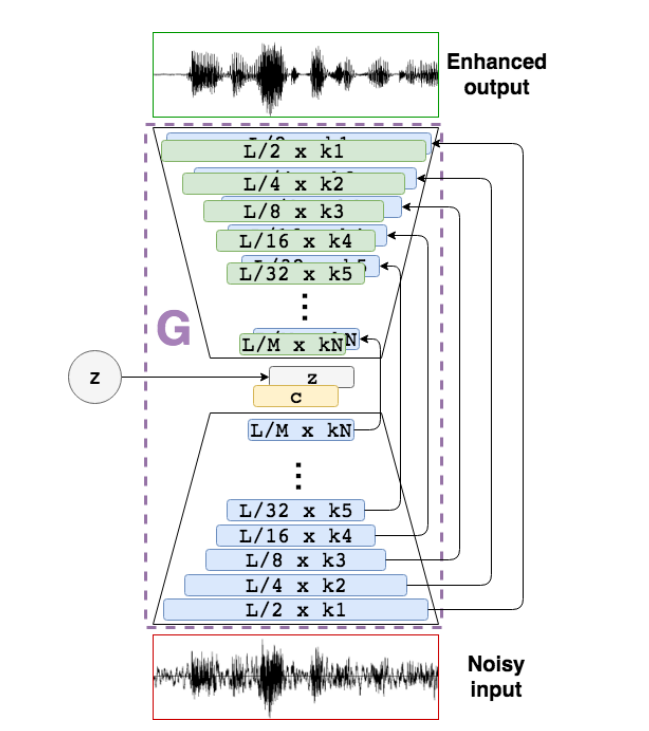

**⏰Scaling of the architecture**

Here there is a more **compact** and **scaled** model in order to achieve a better performance in terms of time-consuming during training.

The model keeps the channel depth relatively small, going up to a maximum of 128 channels. This is a significant reduction compared to the original SEGAN model.
This reduction in channel depth leads to fewer parameters and lower computational complexity, making the model more suitable for environments with limited resources.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Defining the encoder layers
        self.enc1 = nn.Conv1d(1, 8, kernel_size=31, stride=2, padding=15)  # Encoding input to 8 channels
        self.enc2 = nn.Conv1d(8, 16, kernel_size=31, stride=2, padding=15) # Encoding to 16 channels
        self.enc3 = nn.Conv1d(16, 32, kernel_size=31, stride=2, padding=15) # Encoding to 32 channels
        self.enc4 = nn.Conv1d(32, 64, kernel_size=31, stride=2, padding=15) # Encoding to 64 channels
        self.enc5 = nn.Conv1d(64, 128, kernel_size=31, stride=2, padding=15) # Encoding to 128 channels

        # Defining the decoder layers with output padding to correct dimension mismatch
        self.dec1 = nn.ConvTranspose1d(128, 64, kernel_size=31, stride=2, padding=15, output_padding=1) # Decoding to 64 channels
        self.dec2 = nn.ConvTranspose1d(64, 32, kernel_size=31, stride=2, padding=15, output_padding=1)  # Decoding to 32 channels
        self.dec3 = nn.ConvTranspose1d(32, 16, kernel_size=31, stride=2, padding=15, output_padding=1)  # Decoding to 16 channels
        self.dec4 = nn.ConvTranspose1d(16, 8, kernel_size=31, stride=2, padding=15, output_padding=1)   # Decoding to 8 channels
        self.dec5 = nn.ConvTranspose1d(8, 1, kernel_size=31, stride=2, padding=15, output_padding=1)     # Decoding to 1 output channel

        # Defining a PReLU activation layer
        self.prelu = nn.PReLU()

    def forward(self, x):
        # Passing through the encoder while applying PReLU activation
        x1 = self.prelu(self.enc1(x))  # Encoding first layer
        x2 = self.prelu(self.enc2(x1)) # Encoding second layer
        x3 = self.prelu(self.enc3(x2)) # Encoding third layer
        x4 = self.prelu(self.enc4(x3)) # Encoding fourth layer
        x5 = self.prelu(self.enc5(x4)) # Encoding fifth layer

        # Passing through the decoder while applying skip connections and PReLU activation
        x = self.prelu(self.dec1(x5))  # Decoding first layer
        x = self.prelu(self.dec2(x + x4[:, :, :x.size(2)])) # Adding skip connection from the fourth encoder layer
        x = self.prelu(self.dec3(x + x3[:, :, :x.size(2)])) # Adding skip connection from the third encoder layer
        x = self.prelu(self.dec4(x + x2[:, :, :x.size(2)])) # Adding skip connection from the second encoder layer
        x = torch.tanh(self.dec5(x + x1[:, :, :x.size(2)]))     # Adding skip connection from the first encoder layer and applying tanh activation
        return x

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # The Discriminator has a similar architecture as the Encoder of the Generator
        self.conv1 = nn.Conv1d(2, 16, kernel_size=31, stride=2, padding=15)
        self.bn1 = nn.BatchNorm1d(16)  # Batch normalization
        self.conv2 = nn.Conv1d(16, 32, kernel_size=31, stride=2, padding=15)
        self.bn2 = nn.BatchNorm1d(32)  # Batch normalization
        self.conv3 = nn.Conv1d(32, 64, kernel_size=31, stride=2, padding=15)
        self.bn3 = nn.BatchNorm1d(64)  # Batch normalization
        self.conv4 = nn.Conv1d(64, 128, kernel_size=31, stride=2, padding=15)
        self.bn4 = nn.BatchNorm1d(128)  # Batch normalization

        # Output layer for Discriminator
        self.fc = nn.Conv1d(128, 1, kernel_size=1, stride=1)  # 1×1 convolution to reduce to a single output

    def forward(self, x):
        x1 = self.bn1(self.conv1(x))
        x1 = F.leaky_relu(x1, 0.3)
        x2 = self.bn2(self.conv2(x1))
        x2 = F.leaky_relu(x2, 0.3)
        x3 = self.bn3(self.conv3(x2))
        x3 = F.leaky_relu(x3, 0.3)
        x4 = self.bn4(self.conv4(x3))
        x4 = F.leaky_relu(x4, 0.3)

        # Final output
        x = self.fc(x4)  # 1D convolution output
        return torch.sigmoid(x)

▶
**Training**



1.   The **Generator** strives to minimize the loss, which means it want to fool the Discriminator into believing its generated data is real.
2.   The **Discriminator**, on the other hand, aims to minimize its loss by accurately distinguish real data from generated data.



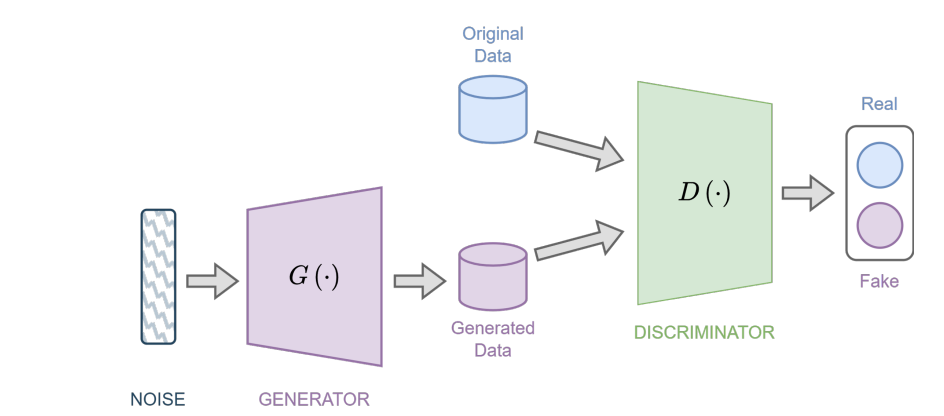

**⚓Loss**

Here showed the equation of the standard loss used in GAN architecture for the adversarial training,

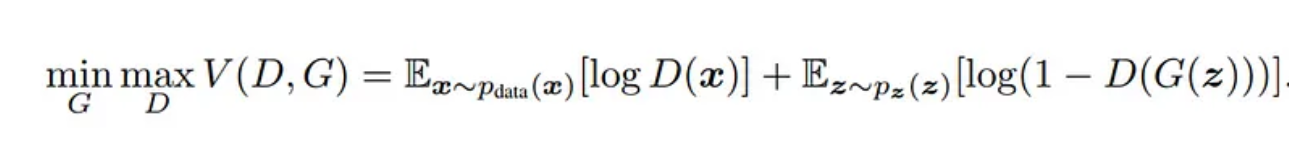

The paper instead suggest a variant with the condinatl LSGAN approaches.

->
**Adaptation for the speech enhancement task**

1.   The concatenation of the noisy with the clean signal should be identified from the discriminator as True.

2.   The concatenation of the noisy with the enhanced signal should be identified from the discriminator as False.

3. The generator want to make True the identification of the discriminator about the concatenation of the noisy with the enhanced signal.



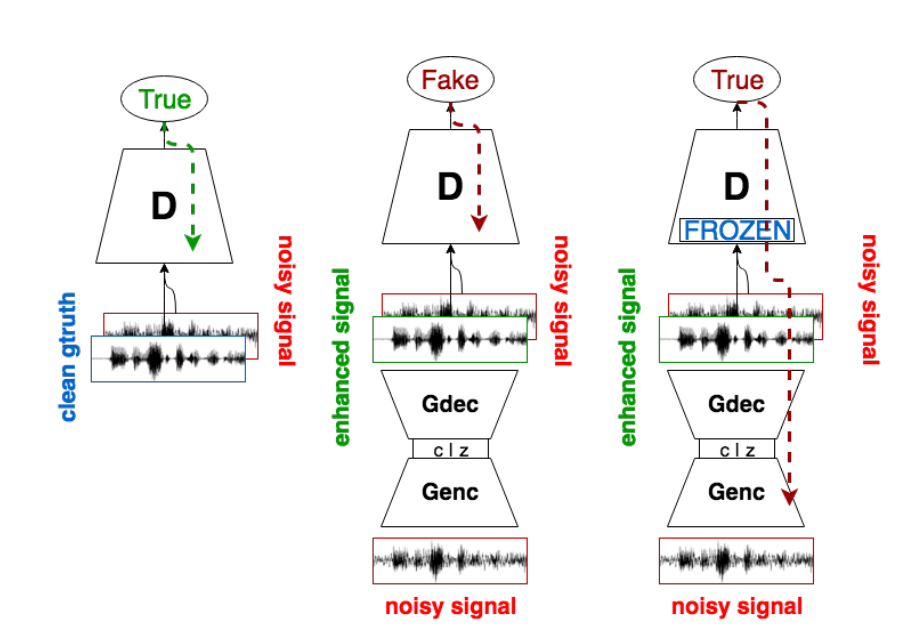

⏰ **VARIANT FOR EXPERIMENT**

Instead of the approach suggested by the paper, in the following code there is the implementation of the **classical GAN loss** with a **L1 regularitazion** term in the generator loss (λ=100) between the enanched audio and the clean one.


⚓
The code also includes:

1. **Model Checkpointing**: The model is saved after every epoch to Google Drive, ensuring progress isn't lost.

2. **Evaluation**: After each epoch, the generator's performance is evaluated on a separate dataset. If there's no improvement in generator loss for a set number of epochs (patience), early stopping is triggered.

In [ ]:
import torch
import random
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import os
from google.colab import drive

#Loading the samples
def load_samples(directory):
    samples = []
    for root_dir, dirs, files in os.walk(directory):
        files.sort()
        for filename in files:
            if filename.endswith('.pt'):
                filepath = os.path.join(directory, filename)
                sample = torch.load(filepath)
                samples.append(sample)
    return samples

class ProcessedAudioDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample= self.samples[idx]
        return sample

# Mounting Google Drive
drive.mount('/content/drive')
waveform_clean_preprocessed_dir = '/content/drive/My Drive/waveform_clean_preprocessed'
waveform_clean_test_preprocessed_dir = '/content/drive/My Drive/waveform_clean_test_preprocessed'
samples = load_samples(waveform_clean_preprocessed_dir)
test_samples= load_samples(waveform_clean_test_preprocessed_dir)

# Creation of the DataLoader
batch_size = 8
Segan_train_dataset = ProcessedAudioDataset(samples)
Segan_test_dataset= ProcessedAudioDataset(test_samples)

# Setting the ratio for the set
eval_ratio = 0.20

# Calculate the sizes of the datasets
total_size = len(Segan_train_dataset)
eval_size = int(total_size * eval_ratio)
train_size = total_size - eval_size

# Splitting the dataset
Segan_train_dataset, Segan_eval_dataset = random_split(Segan_train_dataset, [train_size, eval_size])

#Creation of the data loader
Segan_train_data_loader = DataLoader(Segan_train_dataset, batch_size=batch_size, shuffle=True)
Segan_eval_data_loader = DataLoader(Segan_eval_dataset, batch_size=batch_size, shuffle=False)
Segan_test_data_loader = DataLoader(Segan_test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.optim as optim
import torch.nn as nn

def loss_function_D(real, fake):
    # Cross-entropy loss for the Discriminator
    criterion = nn.BCELoss()

    # Real and fake labels
    real_labels = torch.ones(real.size(0), 1, real.size(2)).to(device)
    fake_labels = torch.zeros(fake.size(0), 1, fake.size(2)).to(device)

    # Discriminator loss
    real_loss = criterion(real, real_labels)
    fake_loss = criterion(fake, fake_labels)
    d_loss = real_loss + fake_loss

    return d_loss

def loss_function_G(fake_out_d,real_data,fake_data,lambda_l1=10):
    # Cross-entropy loss for the Generator
    criterion = nn.BCELoss()
    real_labels = torch.ones(fake_out_d.size(0), 1, fake_out_d.size(2)).to(device)
    # Generator loss
    g_loss = criterion(fake_out_d, real_labels)

    # L1 loss for regularization
    l1_loss = torch.mean(torch.abs(fake_data - real_data))

    # Total Generator loss with L1 regularization
    total_g_loss = g_loss + lambda_l1 * l1_loss

    return total_g_loss

drive.mount('/content/drive')

# Creating the directory for the checkpoint if it doesn't exist
checkpoint_dir = '/content/drive/My Drive/Segan_model_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Defining the filename for the checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pth')

def save_checkpoint(epoch, generator, discriminator, g_optimizer, d_optimizer, checkpoint_path):
    # Saving the model state and optimizers
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict()
    }, checkpoint_path)

def load_checkpoint(checkpoint_path, generator, discriminator, g_optimizer, d_optimizer):
    # Loading the model state  and optimizers
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    return checkpoint['epoch']


def train(generator, discriminator,train_dataloader, num_epochs, lr, checkpoint_path, eval_dataloader, patience):
    # Initializing optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

    best_g_loss = float('inf')  # Tracking best generator loss on evaluation dataset
    epochs_without_improvement = 0  # Counter for epochs without improvement

    for epoch in range( num_epochs):
        # Loading the model if it's not the first epoch
        if epoch > 0 and os.path.exists(checkpoint_path):
            load_checkpoint(checkpoint_path, generator, discriminator, g_optimizer, d_optimizer)
            print(f"Model loaded from {checkpoint_path} at the start of epoch {epoch + 1}")

        # Setting model to training mode
        generator.train()
        discriminator.train()

        # Initializing loss accumulators for each epoch
        total_d_loss = 0.0
        total_g_loss = 0.0

        for real_data in train_dataloader:
            batch_size = real_data.size(0)
            clean_data = real_data.to(device)
            noise = torch.randn_like(real_data) * random.uniform(0, 0.3)  # Adding random gaussian noise to the data
            noisy_data = clean_data + noise

            # Training the discriminator
            d_optimizer.zero_grad()

            enhanced_data = generator(noisy_data)

            # Getting discriminator outputs
            real_out_d = discriminator(torch.cat((noisy_data, clean_data), dim=1))
            fake_out_d = discriminator(torch.cat((noisy_data, enhanced_data), dim=1))

            # Calculating discriminator loss
            d_loss = loss_function_D(real_out_d, fake_out_d)
            d_loss.backward(retain_graph=True)
            d_optimizer.step()

            # Accumulating discriminator loss
            total_d_loss += d_loss.item()

            # Training the generator
            g_optimizer.zero_grad()
            fake_out_d = discriminator(torch.cat((noisy_data, enhanced_data), dim=1))

            # Calculating generator loss
            g_loss = loss_function_G(fake_out_d, clean_data, enhanced_data)
            g_loss.backward()
            g_optimizer.step()

            # Accumulating generator loss
            total_g_loss += g_loss.item()

            # Calculating average losses for the epoch
            avg_d_loss = total_d_loss / len(train_dataloader)
            avg_g_loss = total_g_loss / len(train_dataloader)

        print(f'Epoch [{epoch + 1}/{num_epochs}], avg_d_loss: {avg_d_loss:.4f}, avg_g_loss: {avg_g_loss:.4f}')

        # Saving checkpoint after each epoch
        save_checkpoint(epoch, generator, discriminator, g_optimizer, d_optimizer, checkpoint_path)

        # Evaluating the model
        if eval_dataloader is not None:
            generator.eval()  # Setting generator to evaluation mode
            discriminator.eval() #Setting discriminator to evaluation mode
            total_eval_loss = 0 # Initializing total evaluation loss

            with torch.no_grad():
                for eval_real_data in eval_dataloader:
                    eval_clean_data = eval_real_data.to(device)
                    noise= torch.randn_like(eval_real_data) *random.uniform(0, 0.3)  # Adding random gaussian noise to the data
                    eval_noisy_data = eval_clean_data + noise
                    eval_enhanced_data = generator(eval_noisy_data)

                    # Calculate generator loss on evaluation dataset
                    eval_fake_out = discriminator(torch.cat((eval_noisy_data, eval_enhanced_data), dim=1))
                    eval_loss = loss_function_G(eval_fake_out, eval_clean_data, eval_enhanced_data)
                    total_eval_loss += eval_loss.item()

                avg_eval_loss = total_eval_loss /len(eval_dataloader)
                print(f'Average evaluation loss after epoch {epoch + 1}: {avg_eval_loss:.4f}')

                # Early Stopping
                if avg_eval_loss < best_g_loss:
                    best_g_loss = avg_eval_loss
                    epochs_without_improvement = 0  # Resetting counter
                else:
                    epochs_without_improvement += 1  # Incrementing counter if no improvement

                if epochs_without_improvement >= patience:
                    print(f'Early stopping at epoch {epoch + 1}, no improvement for {patience} epochs.')
                    break  # Exiting training loop if no improvements

# Setting the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs=40
lr=0.0002
patience=4

# Initializing the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Call the training function
train(generator, discriminator, Segan_train_data_loader, epochs, lr, checkpoint_path, Segan_eval_data_loader, patience)


**▶Testing**


⚓Testing considering the average loss.

In [ ]:
def test(generator, test_dataloader):
    # Setting the generator to evaluation mode
    generator.eval()
    total_loss = 0 # Initializing total loss


    # Disabling gradient computation for testing
    with torch.no_grad():
        for real_data in test_dataloader:
            batch_size = real_data.size(0)
            test_clean_data = real_data.to(device)
            test_noisy_data = real_data + torch.randn_like(real_data) * random.uniform(0, 0.3)
            test_enhanced_data = generator(noisy_data)

            # Calculate generator loss on test dataset
            test_fake_out = discriminator(torch.cat((test_noisy_data, test_enhanced_data), dim=1))
            test_loss = loss_function_G(test_fake_out, test_clean_data, test_enhanced_data)
            total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss /len(test_dataloader)
        print(f'Average test loss after epoch {epoch + 1}: {avg_test_loss:.4f}')


# Calling the testing function with the test set
test(generator, Segan_test_data_loader)

